In [2]:
import torch
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data_loader import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models import AutoEncoder, train_model, CombinedLoss
from torch.optim import Adam

## Data Loading

Config initialisation

In [3]:
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

In [4]:
data = reader.read_parquet(FILE_KEY_S3)
data.head()

date_id,feature_05,feature_06,feature_07,feature_08,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,…,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_responder_0_shifted,feature_responder_1_shifted,feature_responder_2_shifted,feature_responder_3_shifted,feature_responder_4_shifted,feature_responder_5_shifted,feature_responder_6_shifted,feature_responder_7_shifted,feature_responder_8_shifted,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,symbol_id,time_id,weight
i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i16,f32
0,0.127298,0.339121,-0.045494,0.151473,-0.038995,-0.644192,-0.193971,-0.016662,-0.213108,-0.045016,0.014899,0.128033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.397016,0.694868,0.812098,-0.128621,0.025559,0.018694,-0.006306,-1.706433,-0.490941,0.425017,0.281025,-0.134582,0.046605,-0.059343,-0.751958,-0.314242,…,0.085259,-0.324355,-0.097414,-0.296044,0.21344,-0.20025,-0.11987,-0.007101,-0.693186,-0.181427,0.073886,-0.062266,0.136151,0.110356,0.055748,-0.028266,0.573992,-0.319932,-0.335376,-0.21128,-0.279558,-0.434355,-1.220439,0.214211,-0.257941,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,1,35,3.889038
0,0.114208,-1.419921,-0.505525,-0.258195,0.017889,-0.254385,0.015691,-0.020583,-0.15111,-0.034961,-0.045215,-0.411787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.037745,-0.824408,-0.312367,0.272155,0.041673,0.051002,0.101001,-0.172871,0.356697,0.43781,-0.243426,0.116691,0.21925,-0.059218,-0.298613,0.029315,…,-0.067586,0.22172,0.347892,0.511532,-0.214167,-0.045423,-0.048534,0.048807,-0.407794,0.008081,-0.071584,0.056597,0.01653,-0.049644,-0.023103,-0.0531,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,1,36,3.889038
0,0.118826,-1.293755,-0.809856,0.268584,-0.056675,-0.273341,-0.016404,0.010669,0.172457,0.011381,0.013246,-0.016248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571682,0.168574,-0.042331,-0.55658,0.175519,-0.052067,0.053939,0.109843,-0.055707,-0.214608,-0.026042,-0.180718,-0.171372,-0.019658,-0.084493,-0.116301,…,-0.100162,-0.029472,0.037072,0.097566,0.061552,-0.136708,-0.029742,-0.047774,-0.150518,-0.287006,-0.000054,-0.048201,-0.093462,-0.015866,0.051347,0.055587,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,1,37,3.889038
0,-0.216346,-0.021069,-0.425764,-0.005701,-0.010654,0.302838,0.000491,-0.017648,-0.036415,-0.008958,0.384812,0.49453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.202302,0.395804,-0.512155,0.642004,0.414221,0.113961,-0.131998,-0.374575,0.206433,-0.445924,-0.518108,0.268771,0.069906,0.207732,-0.046667,-0.266864,…,0.036929,-0.176699,-0.503255,-0.449954,-0.134894,0.050516,-0.089379,0.004014,-0.204778,-0.144482,-0.082102,-0.050271,0.020269,-0.008658,0.096835,-0.042524,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,0.423799,-0.195033,0.145029,-0.076218,-0.304814,0.098249,-0.606483,-0.01076,-0.134628,1,38,3.889038
0,-0.660073,2.168059,0.903407,-0.101644,0.133174,-0.212203,-0.217244,0.006182,-0.076704,-0.027879,0.249095,-0.431726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.511043,-0.221639,-0.0

Define features and target

In [5]:
target = "responder_6"
features = [col for col in data.columns if "feature" in col]

X, y = data[features], data[target]

Split data

In [6]:
n = X.height
n_train = int(0.8 * n)
X_train = X.slice(0, n_train)
y_train = y.slice(0, n_train)

X_val = X.slice(n_train)
y_val = y.slice(n_train)

Data Wraper

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        y = torch.tensor(y.to_numpy(), dtype=torch.float32)
        if y.ndim == 1:
            y = y.view(-1, 1)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [9]:
train_data_loader = DataLoader(
    train_dataset, batch_size=2048, shuffle=False, num_workers=8
)
val_data_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=8)

## Model Evaluation

Model hyperameters

In [10]:
n_feat = len(features)
n_latent = 16
encoder_hidden = [64, 32, 32]
decoder_hidden = [32, 64]
head_hidden = [8, 8, 4]

In [11]:
model = AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
)

Training hyperparameters

In [15]:
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alpha = 1.0
beta = 1.0

In [16]:
optimizer = Adam(model.parameters(), lr=lr)
criterion = CombinedLoss(alpha=alpha, beta=beta)
n_epochs = 20

  5%|▌         | 1/20 [00:14<04:38, 14.67s/it]

Epoch 01 | loss=112.458 | R2_rec_train=0.2598 | R2_rec_val=0.2611 | R2_sup_train=0.7286 | R2_sup_val=0.7082


 10%|█         | 2/20 [00:22<03:13, 10.73s/it]

Epoch 02 | loss=84.047 | R2_rec_train=0.2996 | R2_rec_val=0.2727 | R2_sup_train=0.8284 | R2_sup_val=0.7411


 15%|█▌        | 3/20 [00:33<03:00, 10.61s/it]

Epoch 03 | loss=83.285 | R2_rec_train=0.3039 | R2_rec_val=0.2725 | R2_sup_train=0.8299 | R2_sup_val=0.7550


 20%|██        | 4/20 [00:42<02:41, 10.09s/it]

Epoch 04 | loss=82.858 | R2_rec_train=0.3058 | R2_rec_val=0.2741 | R2_sup_train=0.8307 | R2_sup_val=0.7625


 25%|██▌       | 5/20 [00:52<02:30, 10.01s/it]

Epoch 05 | loss=82.550 | R2_rec_train=0.3069 | R2_rec_val=0.2739 | R2_sup_train=0.8313 | R2_sup_val=0.7665


 30%|███       | 6/20 [01:03<02:25, 10.38s/it]

Epoch 06 | loss=82.297 | R2_rec_train=0.3084 | R2_rec_val=0.2743 | R2_sup_train=0.8317 | R2_sup_val=0.7715


 35%|███▌      | 7/20 [01:12<02:08,  9.85s/it]

Epoch 07 | loss=82.017 | R2_rec_train=0.3098 | R2_rec_val=0.2749 | R2_sup_train=0.8321 | R2_sup_val=0.7746


 40%|████      | 8/20 [01:21<01:56,  9.68s/it]

Epoch 08 | loss=81.667 | R2_rec_train=0.3119 | R2_rec_val=0.2769 | R2_sup_train=0.8324 | R2_sup_val=0.7819


 45%|████▌     | 9/20 [01:30<01:44,  9.48s/it]

Epoch 09 | loss=81.311 | R2_rec_train=0.3143 | R2_rec_val=0.2805 | R2_sup_train=0.8327 | R2_sup_val=0.7885


 50%|█████     | 10/20 [01:39<01:33,  9.38s/it]

Epoch 10 | loss=81.041 | R2_rec_train=0.3156 | R2_rec_val=0.2803 | R2_sup_train=0.8330 | R2_sup_val=0.7966


 55%|█████▌    | 11/20 [01:49<01:26,  9.59s/it]

Epoch 11 | loss=80.786 | R2_rec_train=0.3169 | R2_rec_val=0.2824 | R2_sup_train=0.8333 | R2_sup_val=0.8046


 60%|██████    | 12/20 [01:58<01:15,  9.44s/it]

Epoch 12 | loss=80.502 | R2_rec_train=0.3185 | R2_rec_val=0.2820 | R2_sup_train=0.8337 | R2_sup_val=0.8141


 65%|██████▌   | 13/20 [02:07<01:04,  9.27s/it]

Epoch 13 | loss=80.214 | R2_rec_train=0.3200 | R2_rec_val=0.2834 | R2_sup_train=0.8341 | R2_sup_val=0.8223


 70%|███████   | 14/20 [02:17<00:56,  9.36s/it]

Epoch 14 | loss=79.952 | R2_rec_train=0.3213 | R2_rec_val=0.2861 | R2_sup_train=0.8345 | R2_sup_val=0.8313


 75%|███████▌  | 15/20 [02:26<00:46,  9.22s/it]

Epoch 15 | loss=79.747 | R2_rec_train=0.3221 | R2_rec_val=0.2865 | R2_sup_train=0.8348 | R2_sup_val=0.8370


 80%|████████  | 16/20 [02:35<00:36,  9.21s/it]

Epoch 16 | loss=79.565 | R2_rec_train=0.3228 | R2_rec_val=0.2867 | R2_sup_train=0.8352 | R2_sup_val=0.8416


 85%|████████▌ | 17/20 [02:41<00:25,  8.42s/it]

Epoch 17 | loss=79.419 | R2_rec_train=0.3231 | R2_rec_val=0.2852 | R2_sup_train=0.8355 | R2_sup_val=0.8449


 90%|█████████ | 18/20 [02:50<00:16,  8.50s/it]

Epoch 18 | loss=79.276 | R2_rec_train=0.3238 | R2_rec_val=0.2864 | R2_sup_train=0.8359 | R2_sup_val=0.8462


 95%|█████████▌| 19/20 [02:57<00:08,  8.11s/it]

Epoch 19 | loss=79.134 | R2_rec_train=0.3238 | R2_rec_val=0.2844 | R2_sup_train=0.8362 | R2_sup_val=0.8473


100%|██████████| 20/20 [03:13<00:00,  9.66s/it]

Epoch 20 | loss=78.998 | R2_rec_train=0.3243 | R2_rec_val=0.2857 | R2_sup_train=0.8366 | R2_sup_val=0.8477


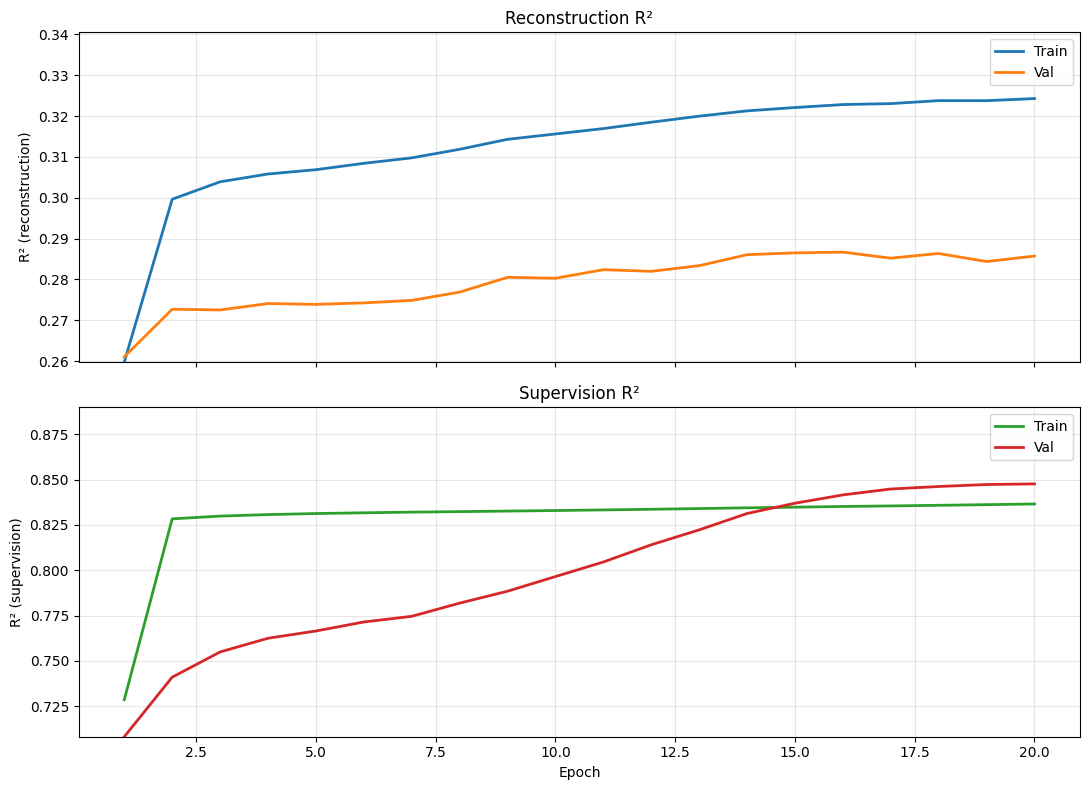

([0.2597862780094147,
  0.29963257908821106,
  0.303901344537735,
  0.3058205842971802,
  0.306871235370636,
  0.3084299564361572,
  0.30976593494415283,
  0.31186792254447937,
  0.31430938839912415,
  0.3156202435493469,
  0.3169374167919159,
  0.31849801540374756,
  0.3199768662452698,
  0.32127735018730164,
  0.3220905661582947,
  0.32282134890556335,
  0.32305416464805603,
  0.3237835168838501,
  0.32377198338508606,
  0.3242911696434021],
 [0.26105397939682007,
  0.2726982831954956,
  0.2725253701210022,
  0.2740938365459442,
  0.2738911211490631,
  0.2742527723312378,
  0.27486956119537354,
  0.2768908143043518,
  0.28051459789276123,
  0.2802882790565491,
  0.2823842167854309,
  0.28198903799057007,
  0.28336870670318604,
  0.28605949878692627,
  0.28650182485580444,
  0.28668877482414246,
  0.2852049767971039,
  0.28635087609291077,
  0.284380704164505,
  0.285717636346817],
 [0.7286285161972046,
  0.8283805847167969,
  0.8299106359481812,
  0.8307399749755859,
  0.831320285797

In [17]:
train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
)